# CS:GO Round Win Prediction with LSTM

This notebook demonstrates how to use the LSTM model to predict CS:GO round outcomes. The model processes sequential data from round frames and outputs win probabilities for each frame within the round.

## Setup

First, let's import the necessary libraries and set up our environment.

In [31]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# Import our package
from mbml.model import LSTMWinPredictor
from mbml.dataset import create_dataloaders
from mbml.train import train_model
from mbml.predict import batch_predict_rounds, visualize_round_predictions

# Set the paths
CSV_PATH = "../round_frame_data.csv"
MODEL_DIR = "../models/lstm_notebook"
OUTPUT_DIR = "../reports/figures/notebook_examples"

# Create directories
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Explore the Data

Let's first take a look at the data to understand its structure.

In [32]:
# Load first few rows of the CSV file
df = pd.read_csv(CSV_PATH, nrows=1000)
print(f"DataFrame shape: {df.shape}")
print(f"\nColumns:\n{df.columns.tolist()}")
df.head()

DataFrame shape: (1000, 21)

Columns:
['round_idx', 'ctTeam', 'tTeam', 'ctBuyType', 'tBuyType', 'ctEqVal', 'tEqVal', 'ctSpend', 'tSpend', 'rnd_winner', 'match_id', 'team1_score', 'team2_score', 'tick', 'seconds', 'clock', 'bomb_planted', 'num_util_ct', 'num_util_t', 'num_ct_alive', 'num_t_alive']


,round_idx,ctTeam,tTeam,ctBuyType,tBuyType,ctEqVal,tEqVal,ctSpend,tSpend,rnd_winner,...,team1_score,team2_score,tick,seconds,clock,bomb_planted,num_util_ct,num_util_t,num_ct_alive,num_t_alive
0,0,BIG,Astralis,Full Eco,Full Eco,1000,1000,3400,3450,T,...,0,0,3711,0.007874,01:55,False,1,4,5,5
1,0,BIG,Astralis,Full Eco,Full Eco,1000,1000,3400,3450,T,...,0,0,3775,0.511811,01:55,False,1,4,5,5
2,0,BIG,Astralis,Full Eco,Full Eco,1000,1000,3400,3450,T,...,0,0,3839,1.015748,01:54,False,1,4,5,5
3,0,BIG,Astralis,Full Eco,Full Eco,1000,1000,3400,3450,T,...,0,0,3903,1.519685,01:54,False,1,4,5,5
4,0,BIG,Astralis,Full Eco,Full Eco,1000,1000,3400,3450,T,...,0,0,3967,2.023622,01:53,False,1,4,5,5


In [3]:
# Check data types and basic statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   round_idx     1000 non-null   int64  
 1   ctTeam        1000 non-null   object 
 2   tTeam         1000 non-null   object 
 3   ctBuyType     1000 non-null   object 
 4   tBuyType      1000 non-null   object 
 5   ctEqVal       1000 non-null   int64  
 6   tEqVal        1000 non-null   int64  
 7   ctSpend       1000 non-null   int64  
 8   tSpend        1000 non-null   int64  
 9   rnd_winner    1000 non-null   object 
 10  match_id      1000 non-null   object 
 11  team1_score   1000 non-null   int64  
 12  team2_score   1000 non-null   int64  
 13  tick          1000 non-null   int64  
 14  seconds       1000 non-null   float64
 15  clock         1000 non-null   object 
 16  bomb_planted  1000 non-null   bool   
 17  num_util_ct   1000 non-null   int64  
 18  num_util_t    1000 non-null  

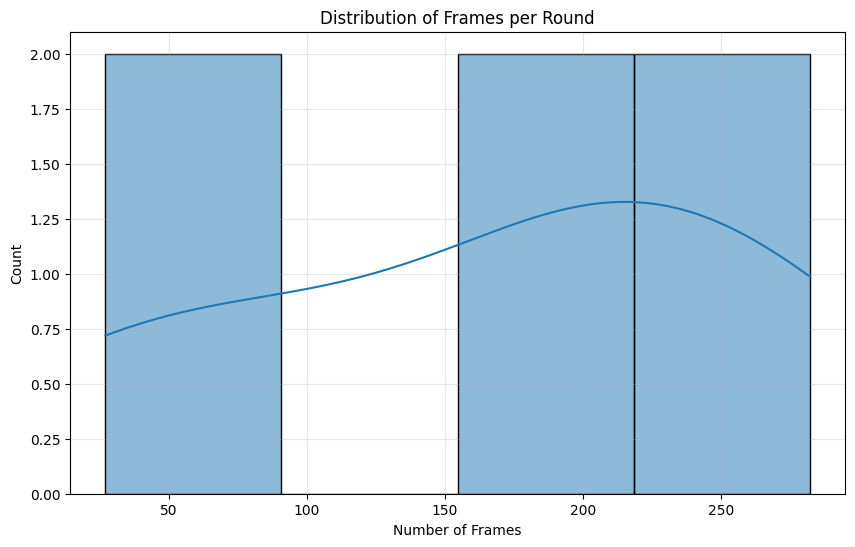

Average frames per round: 166.7
Minimum frames per round: 27
Maximum frames per round: 282


In [4]:
# Explore round distribution
round_counts = df.groupby(['match_id', 'round_idx']).size()
plt.figure(figsize=(10, 6))
sns.histplot(round_counts, kde=True)
plt.title('Distribution of Frames per Round')
plt.xlabel('Number of Frames')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

print(f"Average frames per round: {round_counts.mean():.1f}")
print(f"Minimum frames per round: {round_counts.min()}")
print(f"Maximum frames per round: {round_counts.max()}")

## 2. Create Dataloaders

Now let's create dataloaders to handle our data efficiently.

In [5]:
# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    csv_path=CSV_PATH,
    batch_size=32,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    preload=True  # Set to False for very large datasets
)

Loading data from ../round_frame_data.csv
Using features: ['ctEqVal', 'tEqVal', 'ctSpend', 'tSpend', 'team1_score', 'team2_score', 'tick', 'seconds', 'num_util_ct', 'num_util_t', 'num_ct_alive', 'num_t_alive']
Found 269 unique rounds
Preloading data...
Preloaded 0/269 rounds
Preloaded 269 rounds
Dataset split: 188 train, 40 val, 41 test


In [6]:
# Examine a batch
batch = next(iter(train_loader))
print(f"Batch keys: {batch.keys()}")
print(f"Features shape: {batch['features'].shape}")  # [batch_size, max_seq_len, input_dim]
print(f"Labels shape: {batch['labels'].shape}")     # [batch_size, max_seq_len]
print(f"Mask shape: {batch['mask'].shape}")         # [batch_size, max_seq_len]

Batch keys: dict_keys(['features', 'labels', 'mask', 'metadata'])
Features shape: torch.Size([32, 307, 12])
Labels shape: torch.Size([32, 307])
Mask shape: torch.Size([32, 307])


## 3. Create and Train the Model

Now, let's create and train our LSTM model.

In [ ]:
# Get input dimension from data
input_dim = batch['features'].shape[-1]
print(f"Input dimension: {input_dim}")

# Set model hyperparameters
hidden_dim = 64
num_layers = 2
dropout = 0.2

# Create model
model = LSTMWinPredictor(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)

print(model)

In [ ]:
# Check if model already exists
model_path = os.path.join(MODEL_DIR, "best_model.pt")

if os.path.exists(model_path):
    print(f"Loading existing model from {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    print(f"Training new model")
    train_results = train_model(
        csv_path=CSV_PATH,
        model_save_dir=MODEL_DIR,
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout,
        batch_size=32,
        num_epochs=10,  # Lower for demonstration
        learning_rate=0.001,
        patience=3
    )
    
    # Load the best model
    model.load_state_dict(torch.load(model_path, map_location=device))

## 4. Evaluate and Visualize

Now let's evaluate the model and visualize the results.

In [ ]:
# Move model to device
model = model.to(device)
model.eval()

# Get a test batch
test_batch = next(iter(test_loader))
features = test_batch['features'].to(device)
labels = test_batch['labels']
mask = test_batch['mask']
metadata = test_batch['metadata']

# Make predictions
with torch.no_grad():
    predictions = model(features).cpu()

In [ ]:
# Visualize predictions for a few examples
n_examples = 3  # Number of examples to visualize

for i in range(min(n_examples, len(metadata))):
    # Get data for this example
    example_preds = predictions[i]
    example_labels = labels[i]
    example_mask = mask[i]
    match_id, round_idx = metadata[i]
    
    # Get non-padded values
    valid_preds = example_preds[example_mask > 0]
    valid_labels = example_labels[example_mask > 0]
    
    # Create visualization
    fig_path = os.path.join(OUTPUT_DIR, f"example_{i}_match_{match_id}_round_{round_idx}.png")
    
    fig = visualize_round_predictions(
        predictions=valid_preds,
        labels=valid_labels,
        match_id=match_id,
        round_idx=round_idx,
        save_path=fig_path
    )
    plt.show()

## 5. Calculate Performance Metrics

Let's calculate some performance metrics for the model on the test set.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_batch(predictions, labels, mask, threshold=0.5):
    """Evaluate predictions for a batch."""
    # Flatten tensors and apply mask
    flat_preds = predictions.view(-1)[mask.view(-1) > 0].numpy()
    flat_labels = labels.view(-1)[mask.view(-1) > 0].numpy()
    
    # Convert to binary predictions
    binary_preds = (flat_preds >= threshold).astype(int)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(flat_labels, binary_preds),
        'precision': precision_score(flat_labels, binary_preds, zero_division=0),
        'recall': recall_score(flat_labels, binary_preds, zero_division=0),
        'f1': f1_score(flat_labels, binary_preds, zero_division=0),
        'roc_auc': roc_auc_score(flat_labels, flat_preds) if len(np.unique(flat_labels)) > 1 else np.nan
    }
    
    return metrics

# Evaluate the batch
metrics = evaluate_batch(predictions, labels, mask)

print("\nPerformance Metrics (Test Batch):")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

## 6. Conclusion

In this notebook, we've demonstrated how to:

1. Load and explore CS:GO round data
2. Create PyTorch dataloaders with proper padding for variable-length sequences
3. Define and train an LSTM model for predicting round outcomes
4. Make predictions and visualize the results
5. Evaluate the model's performance

The model provides win probabilities at each time step of a round, which could be useful for real-time CS:GO match analysis and commentary.